In [26]:
import pandas as pd
import os
from tqdm import tqdm

from torch.utils.data import DataLoader
df = pd.read_csv("/root/histology_lib/data/train.csv")

In [76]:
target_name = "Target 1 - Гистологический класс"
df_train = df.head(10)

In [77]:
d = {'Пилоидная астроцитома': 0, 'Диффузная астроцитома': 1,
       'Олигоастроцитома': 2, 'Анапластическая астроцитома': 3, 'Глиобластома': 4,
       'Плеоморфная ксантоастроцитома': 5, 'Олигодендроглиома': 6,
       'Анапластическая олигодендроглиома': 7,
       'Анапластическая олигоастроцитома': 8}

d_ru2en = {
       'Пилоидная астроцитома': 'pyloid astrocytoma', 
       'Диффузная астроцитома': 'diffuse astrocytoma',
       'Олигоастроцитома': "oligoastrocytoma", 
       'Анапластическая астроцитома':  "anaplastic astrocytoma",
       'Глиобластома':  "glioblastoma",
       'Плеоморфная ксантоастроцитома': "pleomorphic xanthoastrocytoma",
       'Олигодендроглиома': "oligodendroglioma",
       'Анапластическая олигодендроглиома': "anaplastic oligodendroglioma",
       'Анапластическая олигоастроцитома':  "anaplastic oligoastrocytoma"
}

In [78]:
train_data = []
train_target = []
for _, i in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    images = [f"{i.path}/{p}" for p in os.listdir(i.path)]
    train_data.extend(
        images
    )
    train_target.extend(
        [d[i[target_name]]] * len(images)
    )

100%|██████████| 100/100 [00:00<00:00, 2267.39it/s]


In [79]:
from vilmedic import AutoModel

model, processor = AutoModel.from_pretrained("mvqa/mvqa-imageclef")

/root/.cache/vilmedic/zoo/models/mvqa/mvqa-imageclef
/root/.cache/vilmedic/zoo/models/mvqa/mvqa-imageclef/labels.tok
Everything has been loaded successfully


In [80]:
test_dataset = processor.inference(image=train_data)['images']

train_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

In [81]:
# model(test_dataset['images'][0].unsqueeze(0).cuda(), from_training=False)

In [82]:
# out = model(**batch, from_training=False)

In [83]:
result = []
for img in train_loader:
    out = model(img.cuda(), from_training=False)
    result.append(out['output'].squeeze(0).detach().cpu().numpy())

In [84]:
# answer = out["answer"][0]

# print(out.keys())
# print(processor.labels_map.idx2label[answer.item()])

In [85]:
from sklearn.manifold import TSNE

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(result)
# Add to dataframe for convenience
x = embs[:, 0]
y = embs[:, 1]

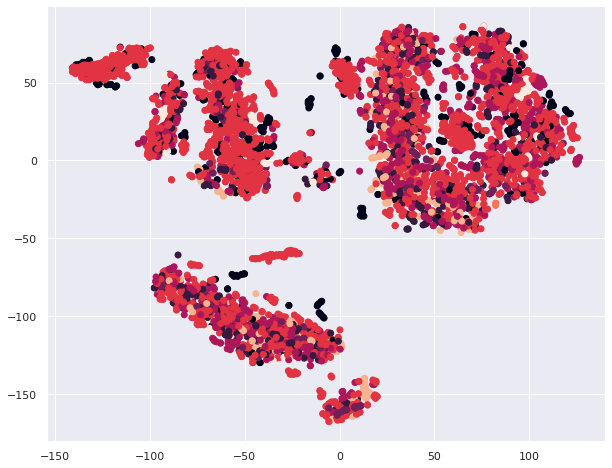

In [86]:
from matplotlib import pyplot as plt

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(x, y, c=train_target);